In [29]:
import sys
from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import spearmanr

sys.path.insert(0, "..")

from validator_tests.eval_validators import _get_correlation, group_by_task_validator
from validator_tests.plot_ranks_vs_acc import get_global_ranks
from validator_tests.utils.constants import TARGET_ACCURACY

In [2]:
df1 = pd.read_pickle(
    "/home/tkm45/NEW_STUFF/2021_experiments/office31_amazon_webcam_fl6_Adam_lr1/all_dfs_processed.pkl"
)
df2 = pd.read_pickle(
    "/home/tkm45/NEW_STUFF/2021_experiments/office31_amazon_webcam_fl3_Adam_lr1/all_dfs_processed.pkl"
)
df = pd.concat([df1, df2], axis=0)

In [41]:
def add_noise(original_df, scale):
    df = original_df.copy()
    df.groupby(["adapter", "trial_num", "epoch"]).size().reset_index().rename(
        columns={0: "count"}
    )
    df = df.rename(columns={"count": "noise"})
    df["noise"] = np.random.normal(scale=scale, size=(len(df)))
    df = original_df.merge(df)
    df[TARGET_ACCURACY] = df[TARGET_ACCURACY] + df["noise"]
    df[TARGET_ACCURACY] = df[TARGET_ACCURACY].clip(lower=0, upper=1)
    return df


def get_correlation(df, per_adapter):
    return _get_correlation(
        df.copy(), per_adapter=per_adapter, src_threshold=0.0, name="weighted_spearman"
    )


def get_acc(df, per_adapter, N):
    df = get_global_ranks(df, rank_by="score", per_adapter=per_adapter)
    df = df[df["rank"] <= N]
    df[f"top_{N}_acc"] = df.groupby(group_by_task_validator(per_adapter))[
        TARGET_ACCURACY
    ].transform("mean")
    keep = ["validator", "validator_args", f"top_{N}_acc"]
    if per_adapter:
        keep += ["adapter"]
    return df[keep].drop_duplicates()

In [ ]:
accs = {}
corr = get_correlation(df, per_adapter=False)
for N in [1, 5]:
    accs[N] = get_acc(df, per_adapter=False, N=N)

s = defaultdict(list)
for scale in np.linspace(0, 0.2, 21):
    s["Noise Standard Deviation"].append(scale)
    df_with_noise = add_noise(df, scale)
    corr_with_noise = get_correlation(df_with_noise, per_adapter=False)
    s["Weighted Spearman Correlation"].append(
        spearmanr(
            corr_with_noise["weighted_spearman"].values,
            corr["weighted_spearman"].values,
        ).correlation
    )
    for N in [1, 5]:
        acc_with_noise = get_acc(df_with_noise, per_adapter=False, N=N)
        s[f"Top {N} Accuracy"].append(
            spearmanr(
                acc_with_noise[f"top_{N}_acc"].values, accs[N][f"top_{N}_acc"].values
            ).correlation
        )

    print(s)

In [43]:
sdf = pd.DataFrame.from_dict(s)

In [44]:
sdf = pd.melt(
    sdf,
    id_vars=["Noise Standard Deviation"],
    value_vars=[
        "Weighted Spearman Correlation",
        "Top 1 Accuracy",
        "Top 5 Accuracy",
    ],
    var_name="Metric",
    value_name="Correlation with original data",
)

<AxesSubplot:xlabel='Noise Standard Deviation', ylabel='Correlation with original data'>

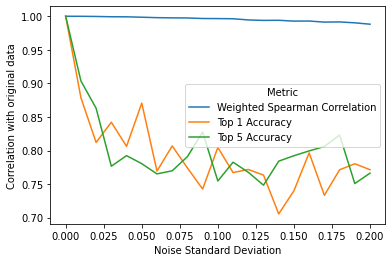

In [45]:
sns.lineplot(data=sdf, x="Noise Standard Deviation", y="Correlation with original data", hue="Metric")